This notebook compares different error metrics for efficiency calculations. The error metrics are:
- clopper pearson confidence interval
- wilson confidence interval
- binomial error
- poisson error

The notebook also compares these metrics for different number of entries. 

In [1]:
from typing import Tuple, Optional
import scipy
import math
import numpy as np
import matplotlib.pyplot as plt
    

def clopper_pearson(passed: float, total: float, level: float = 0.68):
    """Estimate the confidence interval for a sampled binomial random
    variable with Clopper-Pearson.
    `x` = number of successes; `n` = number trials; `alpha` = the confidence level.
    The function returns a `(low, high)` pair of numbers indicating the interval on the probability.
    """
    alpha = (1 - level) / 2
    lo = scipy.stats.beta.ppf(alpha, passed, total - passed + 1) if passed > 0 else 0.0
    hi = scipy.stats.beta.ppf(1 - alpha, passed + 1, total - passed) if passed < total else 1.0
    average = passed / total
    return (average - lo, hi - average)

def wilson(passed: float, total: float, level: float = 0.68):
    """
    Wilson errors.
    https://root.cern.ch/doc/master/classTEfficiency.html#aab172086c12300672a41ab7338c05521
    """
    alpha = (1 - level) / 2
    kappa = scipy.stats.norm.ppf(1 - alpha)
    average = passed / total

    numerator = passed + 0.5 * kappa**2
    denominator = total + kappa**2
    mode = numerator / denominator

    delta = kappa / denominator * math.sqrt(passed * (1 - passed / total) + kappa**2 / 4)
    
    num_digits = 6
    lower_bound = round(max(0, mode - delta), num_digits)
    upper_bound = round(min(1, mode + delta), num_digits)
    return (average - lower_bound, upper_bound - average)

def binomial(passed: float, total: float):
    """
    Binomial errors.
    https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
    """
    p_hat = passed / total
    delta = math.sqrt(p_hat * (1 - p_hat) / total)
    return (delta, delta)

def poisson(passed: float, total: float):
    """
    Poisson errors
    """
    p_hat = passed / total
    delta = p_hat * math.sqrt((passed + total) / (passed * total)) if passed != 0 and total != 0 else 0.0
    return (delta, delta)

def evaluate_different_errors(N: int = 10, ylim: Optional[Tuple[float, float]] = (-0.5, 1.0), no_poisson: bool = True):
    delta = 0.1
    true_eff = np.arange(0, 1+delta, delta)
    passed_evts = N * true_eff

    errors = np.array([clopper_pearson(x, N) for x in passed_evts]).T
    wilson_errors = np.array([wilson(x, N) for x in passed_evts]).T
    binomial_errors = np.array([binomial(x, N) for x in passed_evts]).T

    y_vals = np.zeros(len(true_eff))
    plt.errorbar(true_eff, y_vals, yerr=errors, fmt='o', label='Clopper-Pearson', markersize=5)
    plt.errorbar(true_eff+0.01, y_vals, yerr=wilson_errors, fmt='o', label='Wilson', markersize=5, ls='--')
    plt.errorbar(true_eff+0.02, y_vals, yerr=binomial_errors, fmt='o', label='Binomial', markersize=5, ls='--')
    if not no_poisson:
        piosson_error = np.array([poisson(x, N) for x in passed_evts]).T
        plt.errorbar(true_eff+0.03, y_vals, yerr=piosson_error, fmt='o', label='Piosson', markersize=5, ls='--')

    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('True efficiency')
    plt.ylabel('Error')
    plt.legend()
    plt.title(f"Error bars for {N} entries")
    plt.show()
    

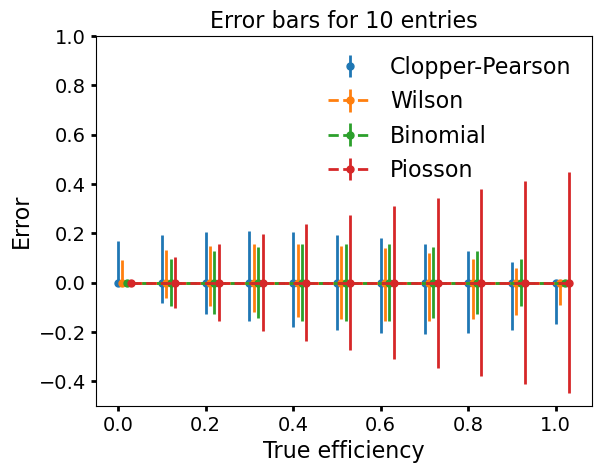

In [2]:
evaluate_different_errors(10, no_poisson=False)

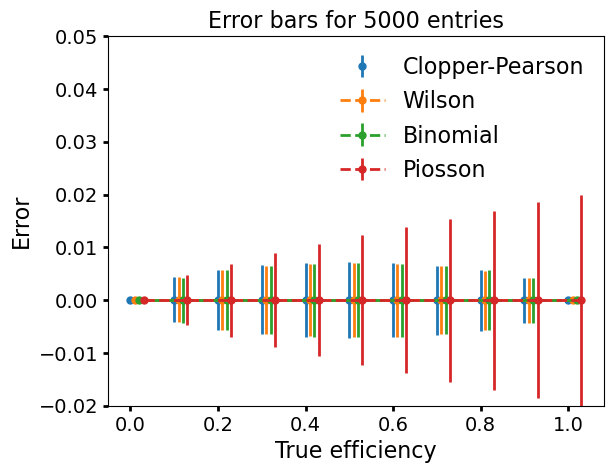

In [3]:
evaluate_different_errors(5000, (-0.02, 0.05), no_poisson=False)

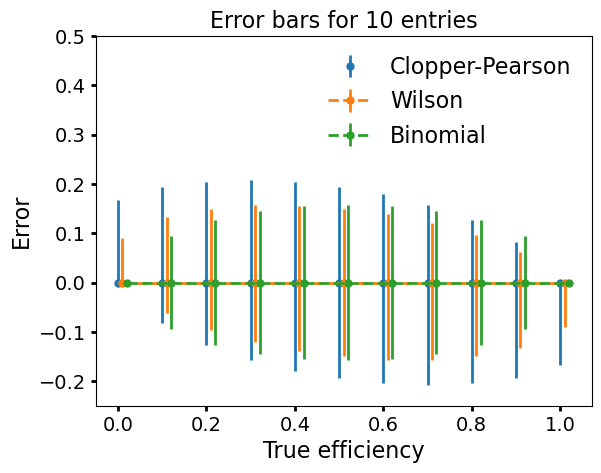

In [8]:
evaluate_different_errors(10, ylim=(-0.25, 0.5))

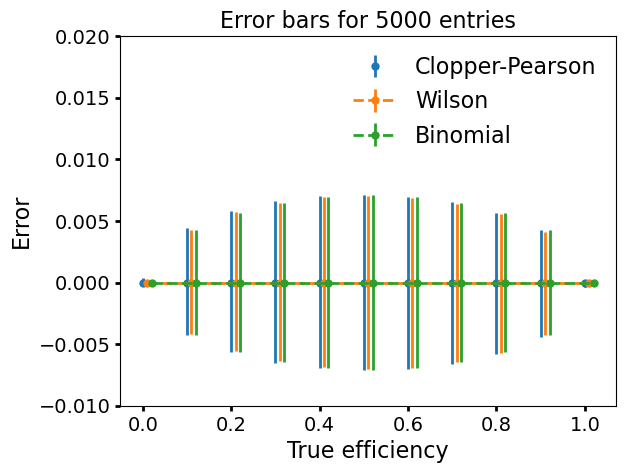

In [4]:
evaluate_different_errors(5000, (-0.01, 0.02))